<a href="https://colab.research.google.com/github/nati-curious/data-science-portfolio/blob/main/clustering_Sklearn_KMeans_DBSCAN_GaussianMixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cluster analysis of earthquake data**

# Libraries and frameworks

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot, cm
plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('ggplot')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, \
adjusted_rand_score, adjusted_mutual_info_score, calinski_harabasz_score
# from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import NearestNeighbors

# from geopy.distance import great_circle
# from shapely.geometry import MultiPoint
from math import radians

#EDA

In [ ]:
# Upload and read a data set
df = pd.read_csv('/content/drive/MyDrive/quake.csv')
df

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0
...,...,...,...,...
2173,13,51.54,-173.11,5.8
2174,97,-10.16,161.01,5.9
2175,527,27.87,139.51,5.8
2176,51,36.43,140.98,6.0


In [ ]:
# Check null values, data types, and shape of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
# Descriptive statistics
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


In [ ]:
# Check for most and less frequent values in a column
df['Focal depth'].value_counts()

0      145
33     121
10      61
45      40
43      36
      ... 
328      1
574      1
333      1
170      1
527      1
Name: Focal depth, Length: 312, dtype: int64

In [ ]:
# Check for min and max values, and for anomalies
df['Focal depth'].sort_values()

887       0
1432      0
2022      0
2017      0
1440      0
       ... 
554     643
1059    647
2053    647
544     653
1989    656
Name: Focal depth, Length: 2178, dtype: int64

In [ ]:
df['Focal depth'].mode()

0    0
dtype: int64

Row 'Focal depth' has the same minimum values several times. It confirms what we can know from domain knowledge that earthquakes could be divided into three categories by deepness:
* shallow (0-70 km);
* intermediate (70 - 300 km);
* deep (300 - 700 km).

Having sorted the data set by the 'Richter' column, we can see that magnitude of the earthquake doesn't depend on focal depth. We see the minimal value of Richter scale in one row with 23, 140 and 214 kilometers and the maximal value in one row with 0 and 159 kilometers. But from the domain knowledge we know that the deepest earthquakes usually are less intensive than shallow. It could be a realtion that we should explore to determine clusters for our data set.

In [ ]:
# Sort data by Richter values
df.sort_values(['Richter'])

,Focal depth,Latitude,Longitude,Richter
2177,41,24.02,122.23,5.8
1694,140,-15.44,167.48,5.8
705,23,-4.84,145.10,5.8
707,214,36.40,70.72,5.8
708,33,-13.18,166.32,5.8
...,...,...,...,...
0,33,-52.26,28.30,6.7
1303,33,-11.16,118.41,6.8
887,0,73.32,54.97,6.8
903,0,70.80,53.92,6.9


In [ ]:
# Sort first by Richter column, then by Focal depth column
df.sort_values(['Richter', 'Focal depth'])

,Focal depth,Latitude,Longitude,Richter
15,0,-44.20,167.96,5.8
92,0,49.88,78.96,5.8
236,0,49.92,77.76,5.8
294,0,19.50,-60.00,5.8
380,0,49.82,78.18,5.8
...,...,...,...,...
806,62,33.34,140.82,6.7
887,0,73.32,54.97,6.8
1303,33,-11.16,118.41,6.8
903,0,70.80,53.92,6.9


Having sorted first by Richter column, then by Focal depth column, we can see that there is a tencdency that shallow earthquakes have less magnitude. Let's check our assumption on a scatterplot of these two variables.

In [ ]:
# Plot a scatter plot showing relationship between Richter and Focal depth values
fig = px.scatter(df, x='Focal depth', y='Richter',
                 title='Relationship between magnitude and focal depth')
fig.show()

We can see a trend resembling a negative relation between the highest values of the magnitude and the focal depth from 0 to approximately 300 kilometers. The more the depth, the less intensity of earthquakes.\
Scientific studies confirm this: "The strength of shaking from an earthquake diminishes with increasing distance from the earthquake's source, so the strength of shaking at the surface from an earthquake that occurs at 500 km deep is considerably less than if the same earthquake had occurred at 20 km depth." Source: https://www.usgs.gov/faqs/what-depth-do-earthquakes-occur-what-significance-depth

In [ ]:
# Visualize a frequency distribution of Focal depth values
counts, bins = np.histogram(df['Focal depth'], bins=range(0, 656, 10))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Focal depth', 'y':'count'},
             title='Focal depth distribution')
fig.show()

On the plot we can see right-skewed bimodal distribution with the most frequent values 5 and 35 kilometers.

In [ ]:
# Check for most and less frequent values in a column
df['Latitude'].value_counts()

 49.88    7
 49.91    7
 49.87    6
 49.92    5
-6.55     5
         ..
 42.09    1
-53.52    1
-16.05    1
-49.35    1
-10.16    1
Name: Latitude, Length: 1824, dtype: int64

In [ ]:
# Check for min and max values, and for anomalies
df['Latitude'].sort_values()

1257   -66.49
603    -63.43
1651   -61.11
826    -61.10
898    -61.05
        ...  
300     73.40
230     73.40
1221    73.41
986     73.41
69      78.15
Name: Latitude, Length: 2178, dtype: float64

In [ ]:
# Visualize a frequency distribution of Latitude values
counts, bins = np.histogram(df['Latitude'], bins=range(-66, 78, 5))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Latitude', 'y':'count'},
             title='Latitude distribution')
fig.show()

On the plot we can see multinomial distribution with the most frequent values at -58.5, -8.5, 16.5, 51.5, 71.5 latitude.

In [ ]:
# Check for most and less frequent values in a column
df['Longitude'].value_counts()

 126.65    5
 78.92     5
 78.86     4
 78.97     4
 151.86    4
          ..
-157.14    1
 166.68    1
 153.60    1
-179.21    1
 122.23    1
Name: Longitude, Length: 1958, dtype: int64

In [ ]:
# Check for min and max values, and for anomalies
df['Longitude'].sort_values()

1112   -179.96
433    -179.95
1803   -179.94
687    -179.88
1823   -179.87
         ...  
968     179.94
216     179.95
1678    179.99
1546    179.99
920     180.00
Name: Longitude, Length: 2178, dtype: float64

In [ ]:
# Check for most and less frequent values in a column
df['Richter'].value_counts()

5.8    691
5.9    518
6.0    370
6.1    228
6.2    158
6.3     95
6.4     53
6.5     44
6.6     11
6.7      6
6.9      2
6.8      2
Name: Richter, dtype: int64

In [ ]:
# Check for min and max values, and for anomalies
df['Richter'].sort_values()

2177    5.8
1694    5.8
705     5.8
707     5.8
708     5.8
       ... 
0       6.7
1303    6.8
887     6.8
903     6.9
812     6.9
Name: Richter, Length: 2178, dtype: float64

Types of earthquakes by intensity

![picture](https://drive.google.com/uc?export=view&id=13HL-VSDwycWO11VlSjYxt85syotbo5Is)
Source: https://www.britannica.com/science/Richter-scale

In our data set we have earthquakes of moderate (5.8, 5.9) and strong (6.0-6.9) intensity.

In [ ]:
# Plot a distribution of Richter column
fig = px.histogram(df, x="Richter", title='Richter distribution')
fig.show()

On the plot we can see a right-skewed distribution of Richter magnitude values from moderate (5.8-5.9) till strong (6.0-6.9) with a mode 5.8.

In [ ]:
# Plot a data set visualization on the world map
fig = go.Figure(data=go.Scattergeo(
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = 'Focal depth: ' + df['Focal depth'].astype(str),
        marker_color = df['Richter'],
        mode = 'markers',
        marker = dict(
            reversescale = True,
            symbol = 'circle',
            line = dict(
                width=0.8,
                color='rgba(102, 102, 102)'
            ),
            cmin = 5.8,
            color = df['Richter'],
            cmax = df['Richter'].max(),
            colorbar_title="Richter scale"
        )))

fig.update_layout(
        title = 'Earthquakes (hover for exact coordinates and focal depth)',
        geo = dict(
            projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.1
        ),
    )

fig.show()

If we compare a scatter plot of earthquakes with a map of tectonic plates, we can see that earthquakes are mostly concentrated along the tectonic fault lines. Notice that most of them belong to the moderate category.

On the picture we see 12 tectonic plates. We know that "Earth's crust, called the lithosphere, consists of 15 to 20 moving tectonic plates" (source: https://oceanservice.noaa.gov/facts/tectonics.html). We can try to use this numbers as a number of clusters.

![picture](https://drive.google.com/uc?export=view&id=1F5-JvZD7qvBfmJuSAngM-NGfq_VR4Ie8)


Also we should take into consideration that in geography there is a notion of seismic belts. There are three major seismic zones:
* the Circum-Pacific belt (also known as the Ring of Fire, or the Pacific Ring of Fire, the Rim of Fire),
* Alpine-Himalayan belt (also known as the Alpide belt, or the Tethyan orogenic belt),
* the Ridge belt.

We can consider three as a number of clusters as well.
![picture](https://drive.google.com/uc?export=view&id=1BeIkJePxZ8c4jXrV_LSzzx7q8YHdD_4N)


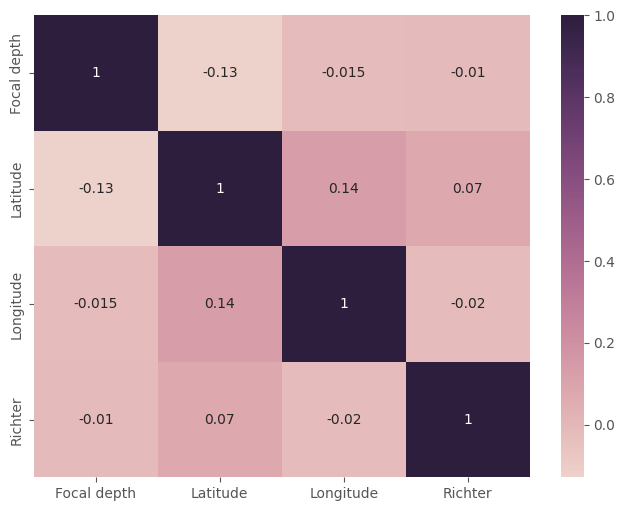

In [ ]:
# Plot a correlation matrix
corr_matrix = df.iloc[:, :].corr()
sns.heatmap(corr_matrix, annot = True, cmap=sns.cubehelix_palette(as_cmap=True));

We don't see any strong correlation on the matrix.

In [ ]:
# Visualize the relationship between features
fig = px.scatter_matrix(df, color = 'Richter')

fig.update_layout(
    title = 'Earthquakes',
    width = 1100,
    height = 1100,
)
fig.show()

In addition to the trend on 'Richter-Focal' depth plot that we discussed earlier, we can see a relation between Focal depth and Longitude. Most earthquakes occurs along the - 170° and 120°-180° longitude. Regarding Latitude - earthquakes are rare on the from 55° to 90° and -40° to -90°. These realtions confirm that earthquakes are clustered by different geographical zones.

# Data preprocessing

As latitude and longitude are measures on a sphere we should convert it to Cartesian coordinates to use it for clustering in K-Means that uses Euclidean distance.

In [ ]:
# Preserving original values of Latitude and Longitude columns to convert it later from Cartesian coordinates for visualization
df_lat_lon = pd.DataFrame(data = df, columns = ['Latitude', 'Longitude'])
df_lat_lon.head()

,Latitude,Longitude
0,-52.26,28.30
1,45.53,150.93
2,41.85,142.78
3,29.19,141.15
4,-21.66,169.81


In [ ]:
# Convert to coordinates
coords_X = np.cos(df['Latitude']) * np.cos(df['Longitude'])
coords_Y = np.cos(df['Latitude']) * np.sin(df['Longitude'])
coords_Z = np.sin(df['Latitude'])

In [ ]:
df_coords = df.copy()
df_coords['Coord_X'] = pd.Series(coords_X)
df_coords['Coord_Y'] = pd.Series(coords_Y)
df_coords['Coord_Z'] = pd.Series(coords_Z)

In [ ]:
df_coords.drop(columns = ['Latitude', 'Longitude'], inplace = True)

In [ ]:
# Rreserve unscaled data of Focal depth and Richter columns for the cluster visualization
df_before_scaling = pd.DataFrame(data = df, columns = ['Focal depth', 'Richter'])
df_before_scaling.head()

,Focal depth,Richter
0,33,6.7
1,36,5.8
2,57,5.8
3,67,6.2
4,30,6.0


In [ ]:
# Data standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_before_scaling)

In [ ]:
df_scaled = pd.DataFrame(data = df_scaled, columns = ['Focal depth', 'Richter'])

Latitude and longitude should not be scaled because this will cause a distortion.

In [ ]:
# Create a data frame with a scaled Focal depth and Richter columns, and latitudes and longitudes mapped to coordinates
df_prep = pd.concat([df_scaled, df_coords['Coord_X'], df_coords['Coord_Y'], df_coords['Coord_Z']],  axis=1)
df_prep.head()

,Focal depth,Richter,Coord_X,Coord_Y,Coord_Z
0,-0.355201,3.816707,0.411020,0.010552,-0.911565
1,-0.329437,-0.935570,0.022886,0.003075,0.999733
2,-0.149088,-0.935570,0.086126,0.525445,-0.846457
3,-0.063208,1.176553,0.594355,-0.133952,-0.792969
4,-0.380965,0.120492,-0.932981,-0.154392,-0.325129


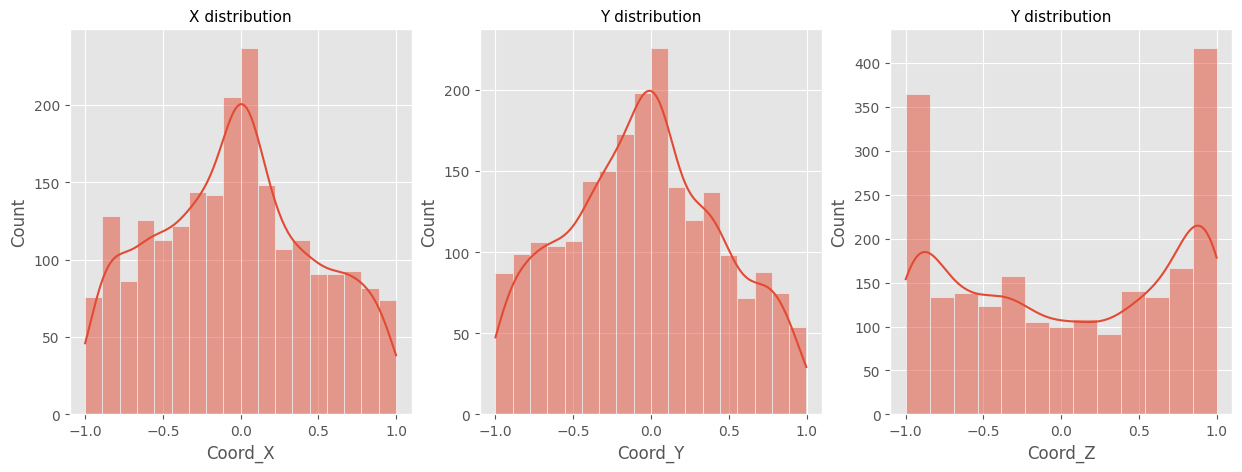

In [ ]:
# Define a number of subplots and a title
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot histplots of X, Y, Z
sns.histplot(x = df_coords['Coord_X'], kde=True, ax=axes[0])
axes[0].set_title('X distribution', fontsize=11)

sns.histplot(x = df_coords['Coord_Y'], kde=True, ax=axes[1])
axes[1].set_title('Y distribution', fontsize=11)

sns.histplot(x = df_coords['Coord_Z'], kde=True, ax=axes[2])
axes[2].set_title('Y distribution', fontsize=11);

# K-Means Clustering

## Finding optimal number of clusters

There are two methods to determine optimal K value: the Elbow
method and the Silhouette coefficient method. Let's build a graph where we can see how inertia, also known as Sum of Squares Errors, changes depending on number of clusters.

### Elbow method

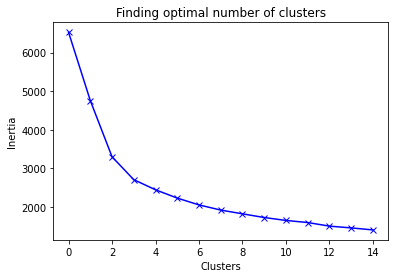

In [ ]:
scores = []

range_values = range(1, 16)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_prep)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding optimal number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

The optimal value of K is when a drop of a line is not steep anymore. In our case it is 3.\
To be more confident in our decision, let's use the Silhouette method.

### Silhouette method

In [ ]:
# Transform data using PCA to visualize the Silhouette method
pca = PCA(n_components=2)

X_2d = pca.fit_transform(df_prep)

In [ ]:
def plot_silhoette(model, X, X_2d, max_num_clusters):
    for n_clusters in range(2, max_num_clusters):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(df_prep, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_2d[:, 0], X_2d[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("\n" + "Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5548809767037167
For n_clusters = 3 The average silhouette_score is : 0.33433666568877934
For n_clusters = 4 The average silhouette_score is : 0.27184688262619877
For n_clusters = 5 The average silhouette_score is : 0.24525475504001581
For n_clusters = 6 The average silhouette_score is : 0.2396045308675058
For n_clusters = 7 The average silhouette_score is : 0.24264223066069965
For n_clusters = 8 The average silhouette_score is : 0.24001034020827405
For n_clusters = 9 The average silhouette_score is : 0.2318049044579453
For n_clusters = 10 The average silhouette_score is : 0.23795241720705526
For n_clusters = 11 The average silhouette_score is : 0.23520717202605487
For n_clusters = 12 The average silhouette_score is : 0.23050760606202575
For n_clusters = 13 The average silhouette_score is : 0.22458575812923026
For n_clusters = 14 The average silhouette_score is : 0.23457014445525687


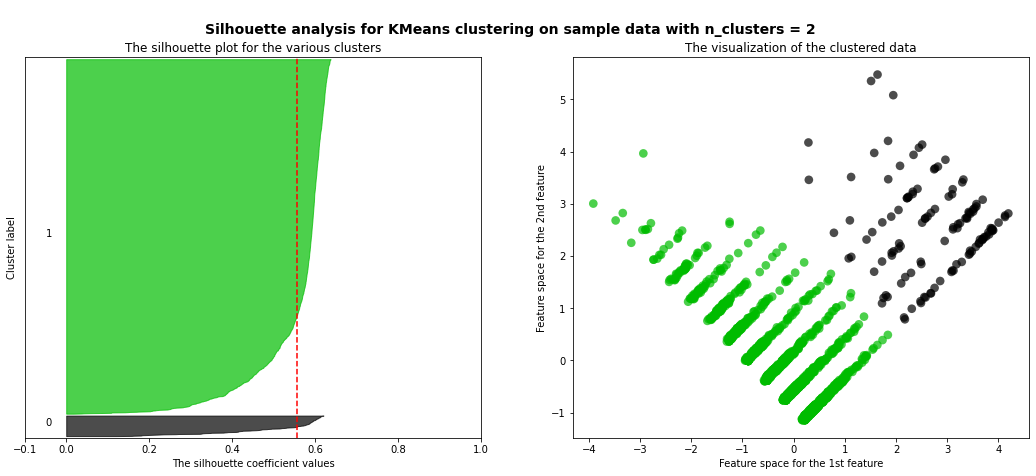

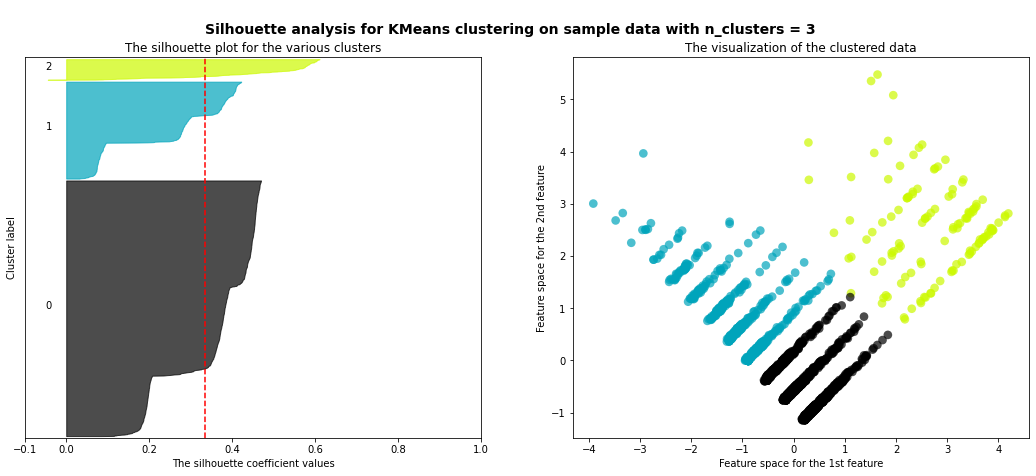

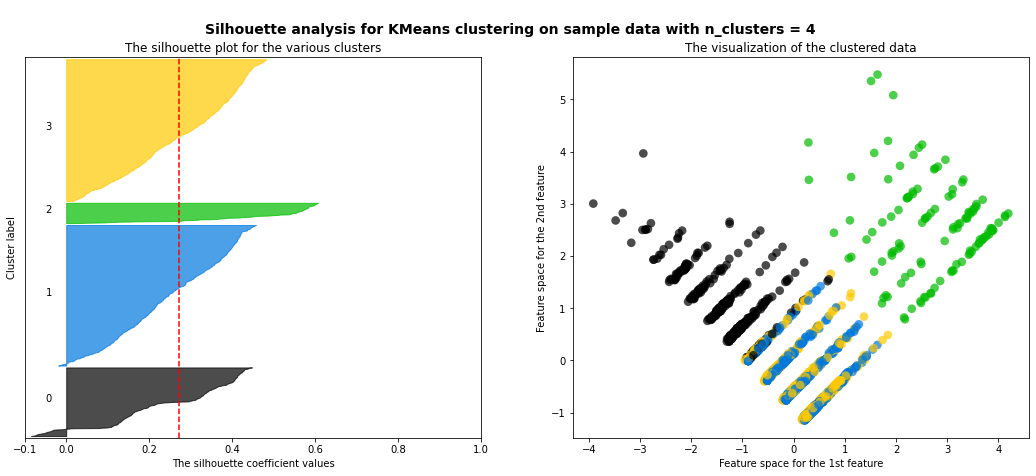

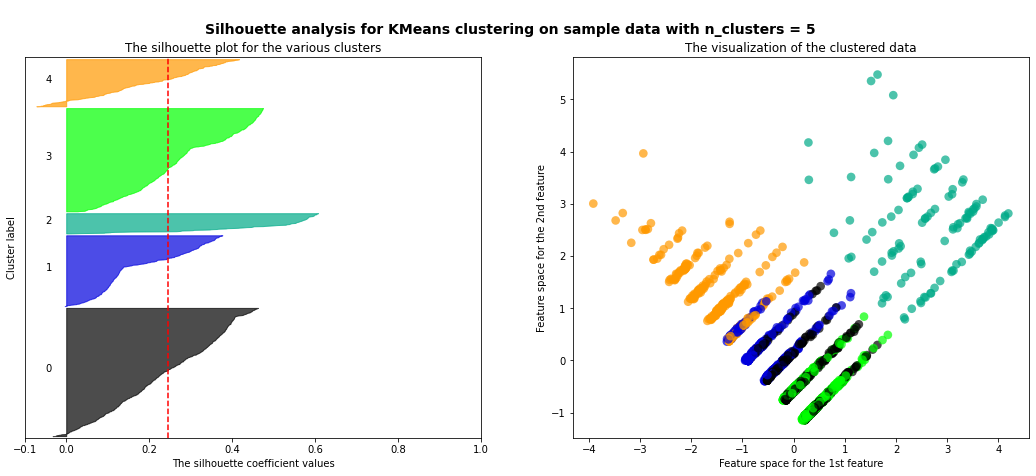

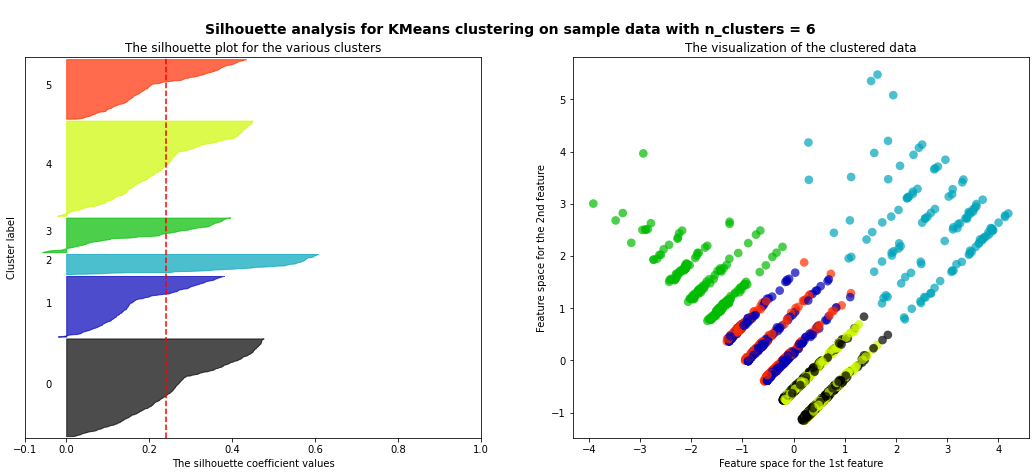

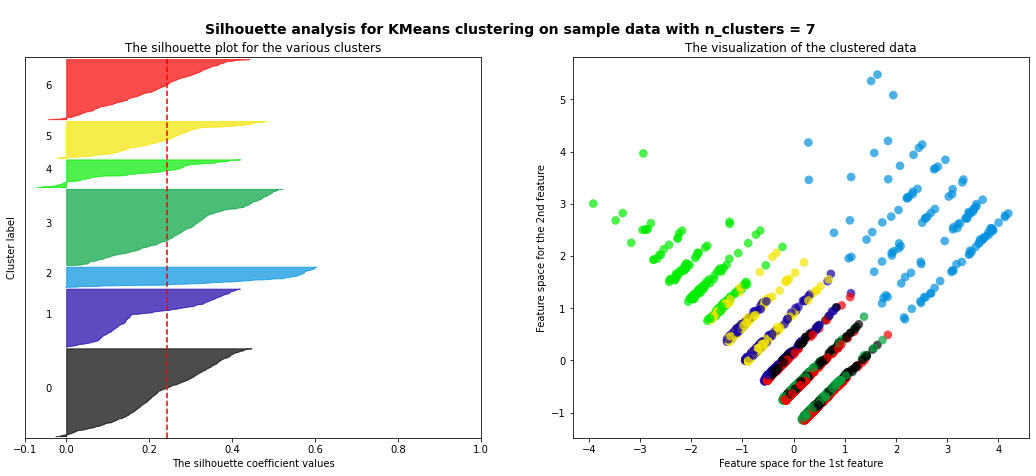

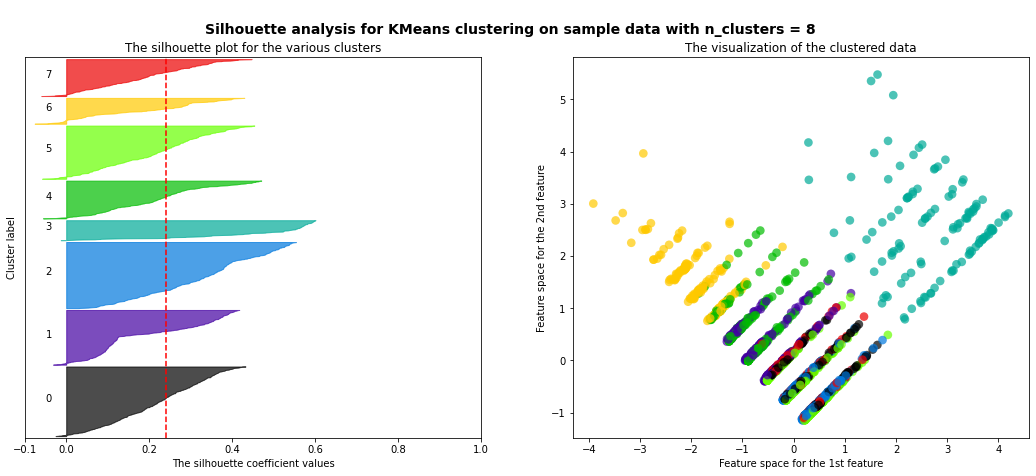

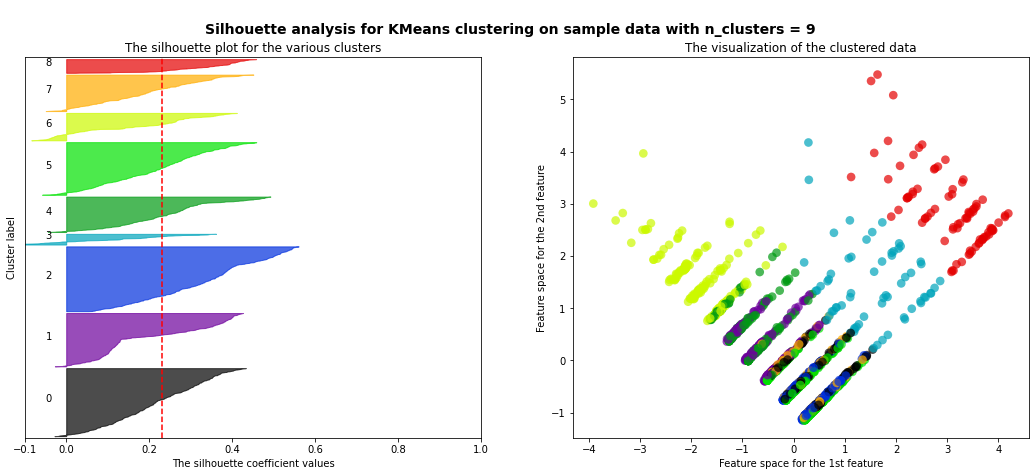

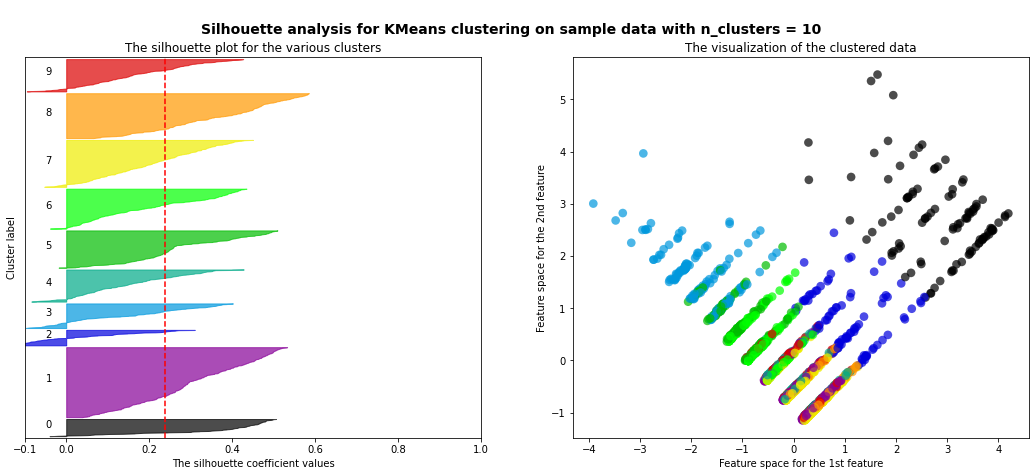

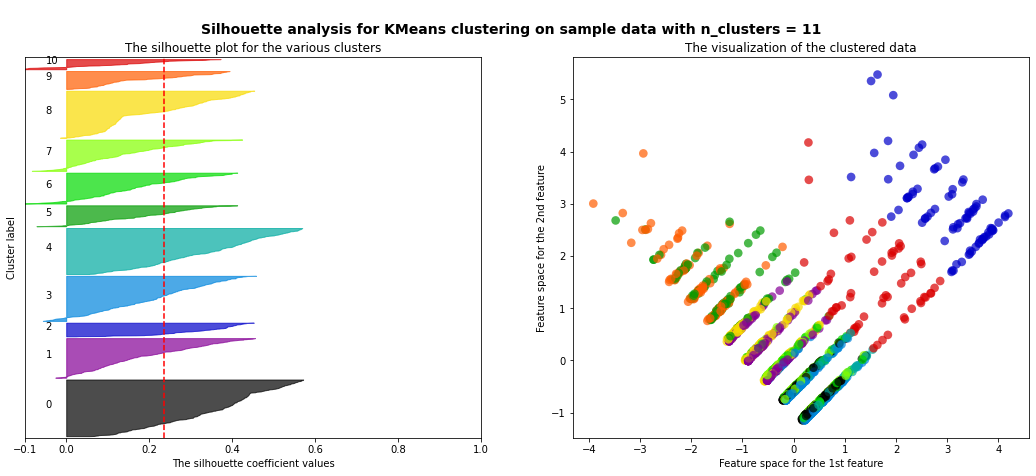

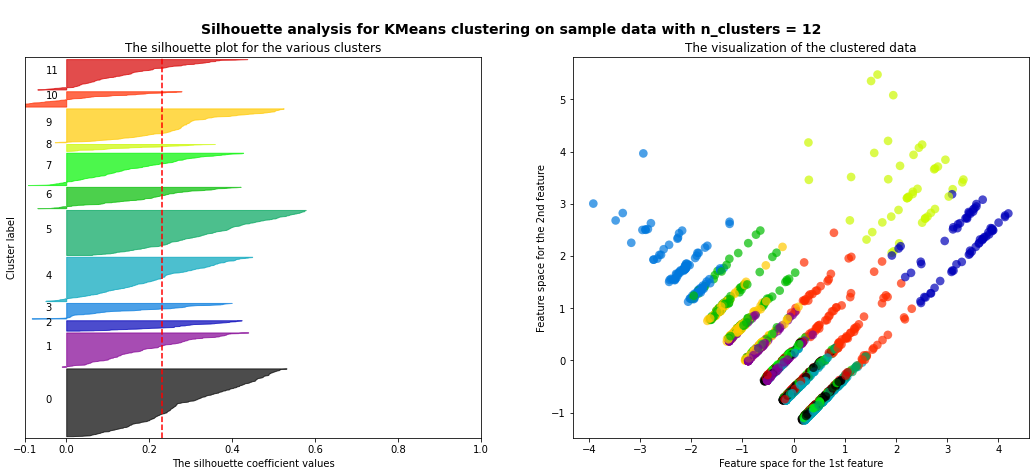

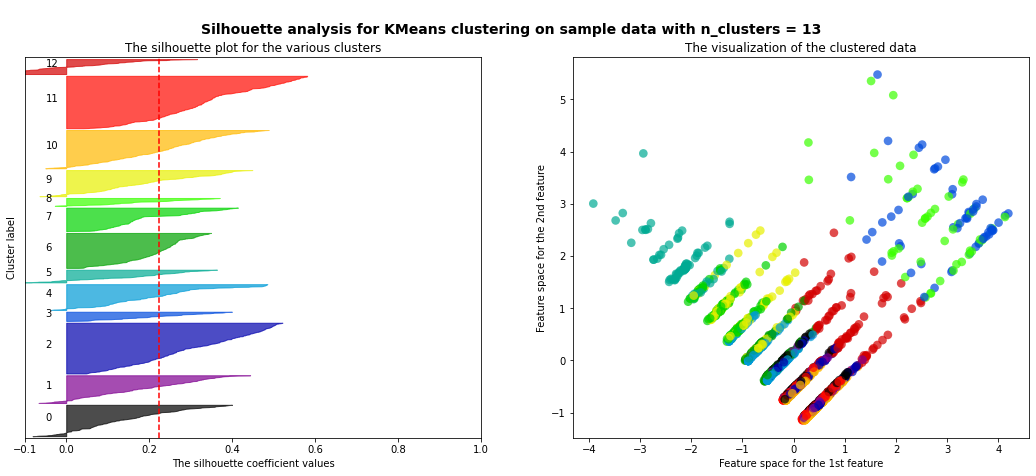

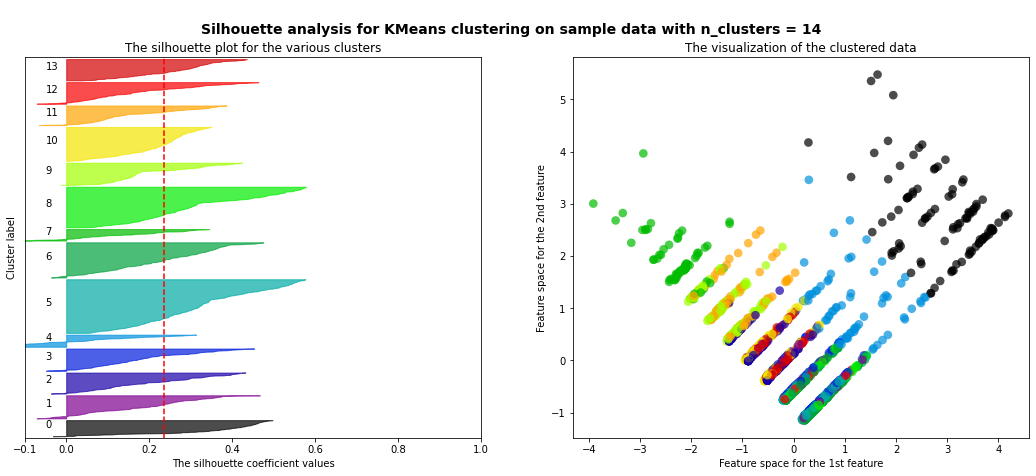

In [ ]:
plot_silhoette(model=KMeans,
               X=df_prep,
               X_2d=X_2d,
               max_num_clusters=15)

The highest score obtained after running code several times with different random states by number of clusters 2. The thickness and size of those 2 clusters are not similar though.\
Notice that 2D plot of clusters resembles Richter-Focal depth pairplot where we can see that data is divided into 2 groups by focal depth less and more 300 km.\
If we look at the plot with 3 clusters we can see that it resembles Richter-Focal depth pairplot even more - after approximately 300 kilometers the corresponding magnitude rarely exceeds 6.3.\
It is worth noting that the score obtained by number 3 is next highest after the score obtained by number 2, and the score of 4 significantly drops and other scores are comparably low.\
With this in mind, I choose 3 as an optimal number of clusters.

## K-Means with optimal number of clusters

In [ ]:
# Cluster the data using K-Means with 3 clusters and get labels
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_prep)
kmeans_labels

array([1, 0, 0, ..., 2, 0, 0], dtype=int32)

### 2D PCA visualization

In [ ]:
# Reduce the original data to a 2D array using PCA with 2 components
pca_2d = PCA(n_components = 2)
principal_comp = pca_2d.fit_transform(df_prep)
principal_comp

array([[-2.89551681,  2.50689327],
       [ 0.38268671, -0.91817031],
       [ 0.57395914, -0.73213866],
       ...,
       [ 3.42299516,  2.02428868],
       [-0.19068683, -0.03429772],
       [ 0.48692892, -0.85209201]])

In [ ]:
# Convert an array to a data frame
pca_2d_df = pd.DataFrame(data = principal_comp, columns = ['pca 1', 'pca 2'])
pca_2d_df.head()

,pca 1,pca 2
0,-2.895517,2.506893
1,0.382687,-0.918170
2,0.573959,-0.732139
3,-0.838947,0.832132
4,-0.336530,-0.203374


In [ ]:
# Concatenate the cluster labels to the data frame
pca_2d_df = pd.concat([pca_2d_df, pd.DataFrame({'cluster':kmeans_labels})], axis = 1)
pca_2d_df.head()

,pca 1,pca 2,cluster
0,-2.895517,2.506893,1
1,0.382687,-0.918170,0
2,0.573959,-0.732139,0
3,-0.838947,0.832132,1
4,-0.336530,-0.203374,0


In [ ]:
fig = px.scatter(pca_2d_df, x='pca 1', y='pca 2', color='cluster')
fig.update_layout(title='Quake types in 2D PCA space (K-Means labels)')
fig.show()

### 3D PCA visualization

In [ ]:
# Reduce the original data to 2D array using PCA with 3 components
pca_3d = PCA(n_components = 3)
principal_comp = pca.fit_transform(df_prep)
principal_comp

array([[-2.89551681,  2.50689327, -0.98522872],
       [ 0.38268671, -0.91817031,  0.96280587],
       [ 0.57395914, -0.73213866, -0.8859059 ],
       ...,
       [ 3.42299516,  2.02428868,  0.56878531],
       [-0.19068683, -0.03429772, -0.99948701],
       [ 0.48692892, -0.85209201, -0.93823002]])

In [ ]:
# Convert an array to a data frame
pca_3d_df = pd.DataFrame(data = principal_comp, columns = ['pca 1', 'pca 2', 'pca 3'])
pca_3d_df.head()

,pca 1,pca 2,pca 3
0,-2.895517,2.506893,-0.985229
1,0.382687,-0.918170,0.962806
2,0.573959,-0.732139,-0.885906
3,-0.838947,0.832132,-0.823158
4,-0.336530,-0.203374,-0.380144


In [ ]:
# Concatenate a column with a cluster label to the data frame
pca_3d_df = pd.concat([pca_3d_df, pd.DataFrame({'cluster':kmeans_labels})], axis = 1)
pca_3d_df.head()

,pca 1,pca 2,pca 3,cluster
0,-2.895517,2.506893,-0.985229,1
1,0.382687,-0.918170,0.962806,0
2,0.573959,-0.732139,-0.885906,0
3,-0.838947,0.832132,-0.823158,1
4,-0.336530,-0.203374,-0.380144,0


In [ ]:
# Visualize clusters in 3D scatterplot
fig = px.scatter_3d(pca_3d_df, x = 'pca 1', y = 'pca 2', z = 'pca 3',
              color = 'cluster', symbol = 'cluster', size_max = 5, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

### Clusters in a scatter plot

In [ ]:
# Add a column with a cluster label corresponding to each data point
df_kmeans_clusters = pd.concat([df_before_scaling, pd.DataFrame({'KMeans Cluster':kmeans_labels})], axis = 1)
df_kmeans_clusters.head()

,Focal depth,Richter,KMeans Cluster
0,33,6.7,1
1,36,5.8,0
2,57,5.8,0
3,67,6.2,1
4,30,6.0,0


In [ ]:
# Plot a scatter plot showing relationship between focal depth and magnitude divided by clusters
fig = px.scatter(df_kmeans_clusters, x="Focal depth", y="Richter", color='KMeans Cluster',
                 title='Relationship between magnitude and focal depth divided by clusters')
fig.show()

In [ ]:
# Number of samples in each cluster
df_kmeans_clusters['KMeans Cluster'].value_counts()

0    1491
1     566
2     121
Name: KMeans Cluster, dtype: int64

On the scatterplot we can see that there are three clusters divided by focal depth and magnitude:
* 1 cluster: Richter 6.1-6.9, Focal depth < 278 km
* 2 cluster: Richter 5.8-6, Focal depth < 278 km
* 3 cluster: Richter 5.8-6.9, Focal depth >= 278 km

Domain knowledge allows us to conclude that the data set's clusters differ in earthquakes' intensity:
* 1 cluster - most inense (1491 quakes),
* 2 cluster - intermediate (566 quakes),
* 3 cluster - less intense (121 quakes).

### Visualization on the world map

In [ ]:
df_clustered = pd.concat([df_lat_lon, df_kmeans_clusters], axis = 1)
df_clustered.head()

,Latitude,Longitude,Focal depth,Richter,KMeans Cluster
0,-52.26,28.30,33,6.7,1
1,45.53,150.93,36,5.8,0
2,41.85,142.78,57,5.8,0
3,29.19,141.15,67,6.2,1
4,-21.66,169.81,30,6.0,0


In [ ]:
df_clustered['Richter'] = df_clustered['Richter'].astype(str)

In [ ]:
df_clustered['text'] = 'Richter: ' + df_clustered['Richter'] + ',' + ' ' + 'Focal depth: ' + df_clustered['Focal depth'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = df_clustered['Longitude'],
        lat = df_clustered['Latitude'],
        text = df_clustered['text'],
        marker_color = df_clustered['KMeans Cluster'],
        mode = 'markers',
        marker = dict(
            reversescale = True,
            symbol = 'circle',
            line = dict(
                width=0.8,
                color='rgba(102, 102, 102)'
            ),
            cmin = 5.8,
            color = df_clustered['KMeans Cluster'],
            cmax = df_clustered['KMeans Cluster'].max(),
            colorbar_title="K-Means Cluster"
        )))

fig.update_layout(
        title = 'Earthquakes (hover for exact coordinates, Richter scale, and focal depth)',
        geo = dict(
            projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.1
        ),
    )

fig.show()

# Gaussian Mixture

For Gaussian Mixture we will set n_components=3 to learn a GMM model as we have determined during K-Means fitting that k=3 produces the best clustering of the data.

In [ ]:
# Cluster the data using Gaussian Mixture model with 3 clusters and get labels
gm = GaussianMixture(n_components=3, random_state=42)
gm_labels = gm.fit_predict(df_prep)
gm_labels

array([1, 0, 0, ..., 2, 1, 0])

In [ ]:
# Reduce the original data to a 2D array using PCA with 3 components
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(df_prep)
principal_comp

array([[-2.89551681,  2.50689327, -0.98522872],
       [ 0.38268671, -0.91817031,  0.96280587],
       [ 0.57395914, -0.73213866, -0.8859059 ],
       ...,
       [ 3.42299516,  2.02428868,  0.56878531],
       [-0.19068683, -0.03429772, -0.99948701],
       [ 0.48692892, -0.85209201, -0.93823002]])

In [ ]:
# Convert an array to a data frame
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca 1', 'pca 2', 'pca 3'])
pca_df.head()

,pca 1,pca 2,pca 3
0,-2.895517,2.506893,-0.985229
1,0.382687,-0.918170,0.962806
2,0.573959,-0.732139,-0.885906
3,-0.838947,0.832132,-0.823158
4,-0.336530,-0.203374,-0.380144


In [ ]:
# Concatenate a column with a cluster label to the data frame
pca_df = pd.concat([pca_df, pd.DataFrame({'GM Cluster':gm_labels})], axis = 1)
pca_df.head()

,pca 1,pca 2,pca 3,GM Cluster
0,-2.895517,2.506893,-0.985229,1
1,0.382687,-0.918170,0.962806,0
2,0.573959,-0.732139,-0.885906,0
3,-0.838947,0.832132,-0.823158,1
4,-0.336530,-0.203374,-0.380144,0


In [ ]:
# Visualize clusters in 3D scatterplot
fig = px.scatter_3d(pca_df, x = 'pca 1', y = 'pca 2', z = 'pca 3',
              color = 'GM Cluster', symbol = 'GM Cluster', size_max = 5, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

In [ ]:
# Concatenate a column with a cluster label corresponding to each data point
df_gm_clusters = pd.concat([df_before_scaling, pd.DataFrame({'GM Cluster':gm_labels})], axis = 1)
df_gm_clusters.head()

,Focal depth,Richter,GM Cluster
0,33,6.7,1
1,36,5.8,0
2,57,5.8,0
3,67,6.2,1
4,30,6.0,0


In [ ]:
fig = px.scatter(df_gm_clusters, x="Focal depth", y="Richter", color='GM Cluster')
fig.show()

# DBSCAN

I conducted some experiments using different features and converting it into different mesuares, using different metrics.

The value of **minPoints** (also known as min_samples) should be at least one greater than the number of dimensions of the dataset. A rule of thumb is min_samples >= 2 * dimensions\
But domain knowledge also determine its value.

The value of **epsilon** can be decided from the K-distance graph. The point of maximum curvature (elbow) in this graph tells us about the value of epsilon.

In [ ]:
nbrs = NearestNeighbors(n_neighbors = 8).fit(df_prep)
distances, indices = nbrs.kneighbors(df_prep)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('K-distance graph')
plt.xlabel('Data points sorted by distance')
plt.ylabel('Epsilon')
plt.grid(True)

In [ ]:
# DBSCAN with default Euclidean metric
dbscan = DBSCAN(eps=1, min_samples=8) # rule of thumb: minPnts = 2 * dim
dbscan_labels = dbscan.fit_predict(df_prep)
dbscan_labels #noisy samples (outliers) are given the label -1

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# Reduce the original data to 2D array using PCA with 3 components
pca_3d = PCA(n_components = 3)
principal_comp = pca.fit_transform(df_prep)
principal_comp

array([[-2.89551681,  2.50689327, -0.98522872],
       [ 0.38268671, -0.91817031,  0.96280587],
       [ 0.57395914, -0.73213866, -0.8859059 ],
       ...,
       [ 3.42299516,  2.02428868,  0.56878531],
       [-0.19068683, -0.03429772, -0.99948701],
       [ 0.48692892, -0.85209201, -0.93823002]])

In [ ]:
# Convert an array to a data frame
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca 1', 'pca 2', 'pca 3'])
pca_df.head()

,pca 1,pca 2,pca 3
0,-2.895517,2.506893,-0.985229
1,0.382687,-0.918170,0.962806
2,0.573959,-0.732139,-0.885906
3,-0.838947,0.832132,-0.823158
4,-0.336530,-0.203374,-0.380144


In [ ]:
# Concatenate the clusters' labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'DBSCAN Cluster':dbscan_labels})], axis = 1)
pca_df.head()

,pca 1,pca 2,pca 3,DBSCAN Cluster
0,-2.895517,2.506893,-0.985229,0
1,0.382687,-0.918170,0.962806,0
2,0.573959,-0.732139,-0.885906,0
3,-0.838947,0.832132,-0.823158,0
4,-0.336530,-0.203374,-0.380144,0


In [ ]:
# Visualize clusters in 3D scatterplot
fig = px.scatter_3d(pca_df, x = 'pca 1', y = 'pca 2', z = 'pca 3', \
              color = 'DBSCAN Cluster', symbol = 'DBSCAN Cluster', size_max = 5, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

DBSCAN divided data into two big and one small groups with a lot of outliers because of specificity of this density-based algorithm.\
We can clearly see that border of two big clusters are demarcated by focal depth value. As we rememeber from K-Means clustering visualization it is approximately 300 km. Earthquakes with focal depth less than 300 km have high and moderate intensity and those with focal depth more than 300 are low intense.

# Clustering quality metrics

For fully unsupervised (without leables) measuring of clustering we can use Calinski-Harabasz score - also known as the Variance Ratio Criterion. High score tells us that clusters are dense and well separated.

"There is no "acceptable" cut-off value. You simply compare CH values by eye. The higher the value, the "better" is the solution."\
Source: https://stats.stackexchange.com/q/52838

In [ ]:
# Calinski-Harabasz score for K-Means clustering
calinski_harabasz_score(df_prep, df_clustered['KMeans Cluster'])

1061.266592650792

In [ ]:
# Calinski-Harabasz score for Gaussian Mixture clustering
calinski_harabasz_score(df_prep, df_gm_clusters['GM Cluster'])

623.9193479185894

In [ ]:
# Calinski-Harabasz score for DBSCAN clustering
calinski_harabasz_score(df_prep, pca_df['DBSCAN Cluster'])

274.83723922048614

For measuring quality of clustering with labels we can use Adjusted Mutual Information (AMI) and adjusted Rand index. Percfect scors are equal to 1.0. We got 0.5 for Gaussian Mixture because as we saw Gaussian Mixture model perfomed not as well as K-Means and 0.38 and 0.23 for DBSCAN that divided data into two meaningful clusters.

In [ ]:
# AMI of Gaussian Mixture clustering with K-Means labels as a ground truth
adjusted_mutual_info_score(df_clustered['KMeans Cluster'], df_gm_clusters['GM Cluster'])

0.5029285308293011

In [ ]:
# Adjust Rand index of Gaussian Mixture clustering with K-Means labels as a ground truth
adjusted_rand_score(df_clustered['KMeans Cluster'], df_gm_clusters['GM Cluster'])

0.5149314302192617

In [ ]:
# AMI of DBSCAN clustering with K-Means labels as a ground truth
adjusted_mutual_info_score(df_clustered['KMeans Cluster'], pca_df['DBSCAN Cluster'])

0.3798243402428578

In [ ]:
# Adjust Rand index of DBSCAN clustering with K-Means labels as a ground truth
adjusted_rand_score(df_clustered['KMeans Cluster'], pca_df['DBSCAN Cluster'])

0.23456525327000394

# Conclusion

K-Means performed best.

Notice that all the clusters created by K-Means have a circular-ish shape. This is because the centroids of the clusters are updated iteratively using the mean value.
Comparing this distance-based model to distribution-based model - Gaussian Mixture - we can notice that clusters have more rectangular form.

DBSCAN determined a lot of points as outliers because it is density-based algorithm. Because of this characteristic it didn't manage to cluster 3 meaningful groups as K-Means did.

# DBSCAN with Haversine distance (additional)

DBSCAN is one of the algorithms that can handle arbitrary distance functions, in particular, geodetic distance functions. It uses haversine distance which properly compute distances between lattitude/longitude points. To use it we should convert these points to radians first.

In [ ]:
# Create a matrix of latitude and longitude values
coords_dbscan = df[['Latitude','Longitude']].to_numpy()

As sklearn documentation says, "the Haversine (or great circle) distance is the angular distance between two points on the surface of a sphere. The first coordinate of each point is assumed to be the latitude, the second is the longitude, given in radians. The dimension of the data must be 2."

In [ ]:
# Convert coordinates into radians
radians = np.radians(coords_dbscan)
radians

array([[-0.91210907,  0.49392818],
       [ 0.79464841,  2.63422544],
       [ 0.73042029,  2.49198111],
       ...,
       [ 0.48642326,  2.43490884],
       [ 0.63582345,  2.46056518],
       [ 0.41922809,  2.13331594]])

In [ ]:
df_dbscan = df.copy()

In [ ]:
df_dbscan.drop(columns = ['Latitude', 'Longitude', 'Focal depth', 'Richter'], inplace = True)

In [ ]:
df_dbscan[['Latitude_rad', 'Longitude_rad']] = pd.DataFrame(data = np.radians(coords_dbscan), columns = [['Latitude_rad', 'Longitude_rad']])
df_dbscan[['Latitude_rad', 'Longitude_rad']].head()

,Latitude_rad,Longitude_rad
0,-0.912109,0.493928
1,0.794648,2.634225
2,0.730420,2.491981
3,0.509462,2.463532
4,-0.378038,2.963744


In [ ]:
# Convert the epsilon input into radian measure
kms_per_radian = 6371.0088
epsilon /= kms_per_radian

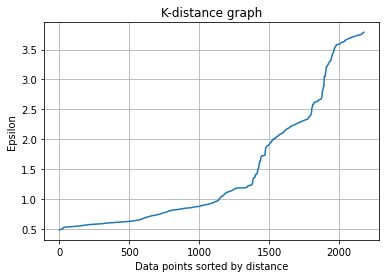

In [ ]:
nbrs = NearestNeighbors(n_neighbors = 700).fit(df_dbscan)
distances, indices = nbrs.kneighbors(df_dbscan)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('K-distance graph')
plt.xlabel('Data points sorted by distance')
plt.ylabel('Epsilon')
plt.grid(True)

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=700, algorithm='ball_tree', metric='haversine')
dbscan_haver_labels = dbscan.fit_predict(df_dbscan)
dbscan_haver_labels

array([-1,  0,  0, ...,  0,  0,  0])

In [ ]:
df_dbscan_clusters = pd.concat([df_lat_lon, pd.DataFrame({'DBSCAN Haver Cluster':dbscan_haver_labels})], axis = 1)
df_dbscan_clusters.head()

,Latitude,Longitude,DBSCAN Haver Cluster
0,-52.26,28.30,-1
1,45.53,150.93,0
2,41.85,142.78,0
3,29.19,141.15,0
4,-21.66,169.81,0


In [ ]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_dbscan_clusters['Longitude'],
        lat = df_dbscan_clusters['Latitude'],
        marker_color = df_dbscan_clusters['DBSCAN Haver Cluster'],
        mode = 'markers',
        marker = dict(
            reversescale = True,
            symbol = 'circle',
            line = dict(
                width=0.8,
                color='rgba(102, 102, 102)'
            ),
            cmin = 5.8,
            color = df_dbscan_clusters['DBSCAN Haver Cluster'],
            cmax = df_dbscan_clusters['DBSCAN Haver Cluster'].max(),
            colorbar_title="DBSCAN Haver Cluster"
        )))

fig.update_layout(
        title = 'Earthquakes (hover for exact coordinates, Richter scale, and focal depth)',
        geo = dict(
            projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.1
        ),
    )

fig.show()